In [1]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


**Part(1)**

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization values can vary
])

dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)

test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
selected_classes = [0, 1, 2]


def filter_classes(data):
    indices = [i for i, (_, label) in enumerate(data) if label in selected_classes]
    
    return torch.utils.data.Subset(data, indices)

# Filter dataset for the selected classes
filtered_dataset = filter_classes(dataset)

filtered_test_dataset = filter_classes(test_dataset)

print("Training Dataset size: ", len(filtered_dataset))

print("Training Dataset size: ", len(filtered_test_dataset))



Training Dataset size:  15000
Training Dataset size:  3000


In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

labels = [label for _, label in filtered_dataset]

train_idx, val_idx = train_test_split( #Stratified Split
    range(len(labels)), 
    test_size=0.2, 
    stratify=labels,
    random_state=42
)

train_dataset = torch.utils.data.Subset(filtered_dataset, train_idx)

val_dataset = torch.utils.data.Subset(filtered_dataset, val_idx)


In [9]:
class Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

train_dataset = Dataset(train_dataset)
val_dataset = Dataset(val_dataset)
test_dataset = Dataset(filtered_test_dataset)


In [11]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


**Part (2)**

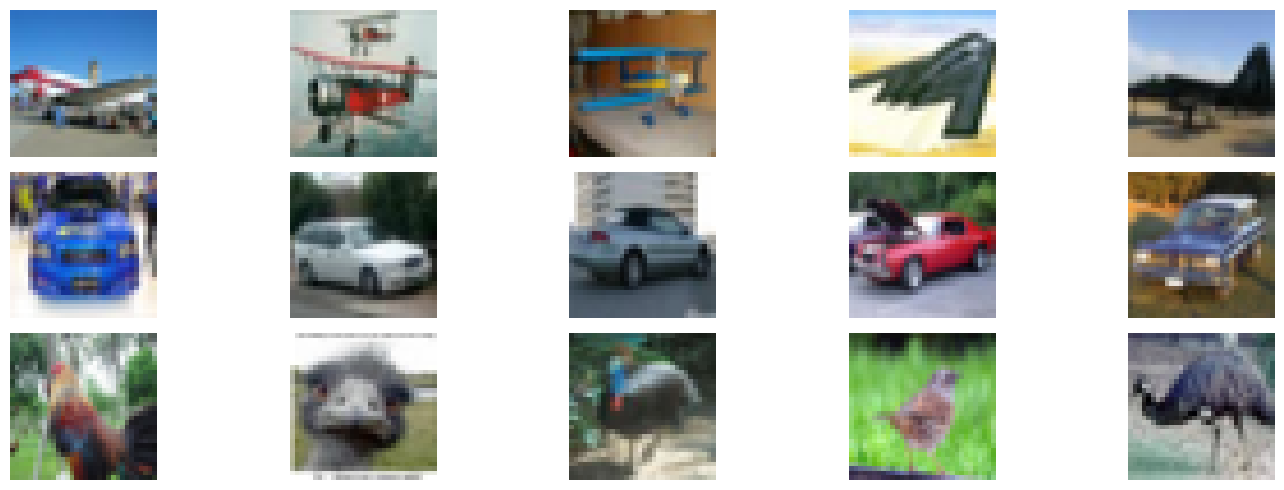

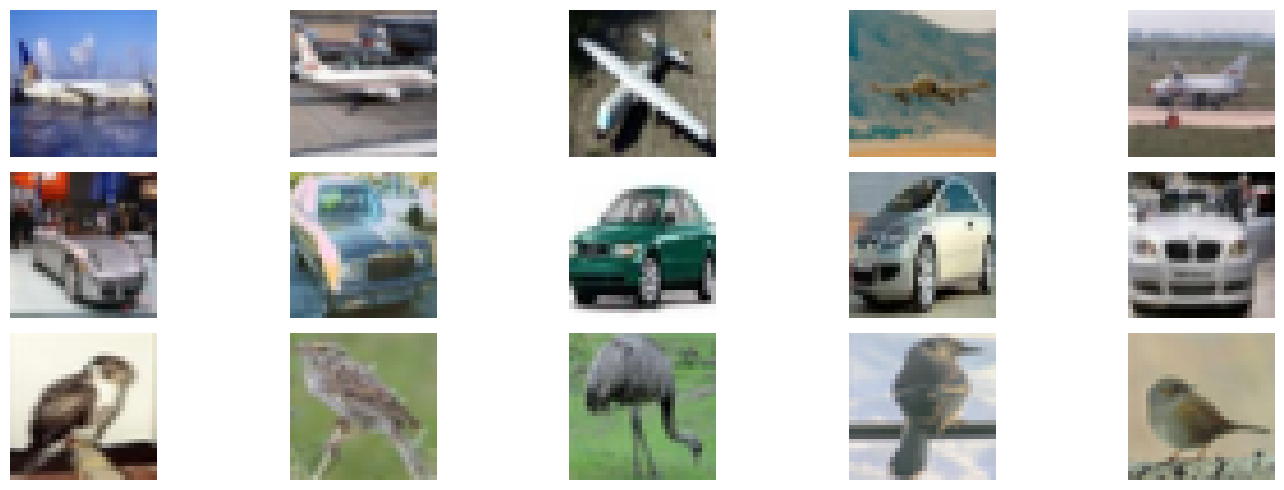

In [14]:
import matplotlib.pyplot as plt

def show_images(dataset, num_images_per_class=5):
    
    class_counts = {cls: 0 for cls in selected_classes}
    
    class_images = {cls: [] for cls in selected_classes}
    
    for img, label in dataset:
        if class_counts[label] < num_images_per_class:
            
            class_images[label].append(img)
            
            class_counts[label] += 1
        if all(count == num_images_per_class for count in class_counts.values()):
            break

    fig, axes = plt.subplots(len(selected_classes), num_images_per_class, figsize=(15, 5))
    
    for i, cls in enumerate(selected_classes):
        for j in range(num_images_per_class):
            
            axes[i, j].imshow((class_images[cls][j].permute(1, 2, 0) * 0.5 + 0.5).numpy())
            
            axes[i, j].axis('off')
            
            if j == 0:
                axes[i, j].set_ylabel(f"Class {cls}", size=14)
                
    plt.tight_layout()
    plt.show()

show_images(train_dataset) #Images from Training Set

show_images(val_dataset) #Images from Validation Set 


**Part (3)**

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def __init__(self, num_classes=3):
        
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        dummy_input = torch.zeros(1, 3, 32, 32)  # Because input images are 32x32
        self.feature_size = self._get_feature_size(dummy_input)
        
        self.fc1 = nn.Linear(self.feature_size, 16)
        
        self.fc2 = nn.Linear(16, num_classes)

    def _get_feature_size(self, x):
        with torch.no_grad():
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            return x.numel()  # Total number of elements in the tensor

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten excluding the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [19]:
num_classes = 3  
model = CNN(num_classes)

**Part (4)**

In [22]:
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn

# Hyperparameters
learning_rate = 0.001
num_epochs = 15
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=learning_rate)

#History for storing training and validation losses as well as training accuracy and validation accuracy over the span of 15 epochs
train_losses, val_losses = [], []

train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train = 0.0, 0
    total_train = 0
    
    # Training phase
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    
    train_accuracies.append(correct_train / total_train)
    
    # Validation phase
    model.eval()
    
    val_loss, correct_val = 0.0, 0
    
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    
    val_accuracies.append(correct_val / total_val)
    
    #Printing the results for each iteration
    
    print(
        f"Epoch Number [{epoch+1}/{num_epochs}]: "
        f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
        f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}"
    )


Epoch Number [1/15]: Train Loss: 0.7330, Train Accuracy: 0.6846, Validation Loss: 0.5999, Validation Accuracy: 0.7530
Epoch Number [2/15]: Train Loss: 0.5394, Train Accuracy: 0.7833, Validation Loss: 0.5533, Validation Accuracy: 0.7820
Epoch Number [3/15]: Train Loss: 0.4794, Train Accuracy: 0.8122, Validation Loss: 0.4697, Validation Accuracy: 0.8147
Epoch Number [4/15]: Train Loss: 0.4481, Train Accuracy: 0.8238, Validation Loss: 0.4308, Validation Accuracy: 0.8360
Epoch Number [5/15]: Train Loss: 0.4088, Train Accuracy: 0.8393, Validation Loss: 0.4266, Validation Accuracy: 0.8280
Epoch Number [6/15]: Train Loss: 0.3914, Train Accuracy: 0.8483, Validation Loss: 0.3940, Validation Accuracy: 0.8470
Epoch Number [7/15]: Train Loss: 0.3594, Train Accuracy: 0.8608, Validation Loss: 0.3799, Validation Accuracy: 0.8487
Epoch Number [8/15]: Train Loss: 0.3467, Train Accuracy: 0.8651, Validation Loss: 0.3588, Validation Accuracy: 0.8590
Epoch Number [9/15]: Train Loss: 0.3315, Train Accuracy:

In [24]:
# Saving the model in the .pth file
torch.save(model.state_dict(), "cnn_model.pth")

print("Model saved to cnn_model.pth")


Model saved to cnn_model.pth


In [26]:
model = CNN(num_classes)

model.load_state_dict(torch.load("cnn_model.pth"))

model.eval()  

/var/folders/0q/sqss7b0n3399xjy7cngwg30w0000gn/T/ipykernel_54481/3620264528.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_model.p

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)

**Part (5)**

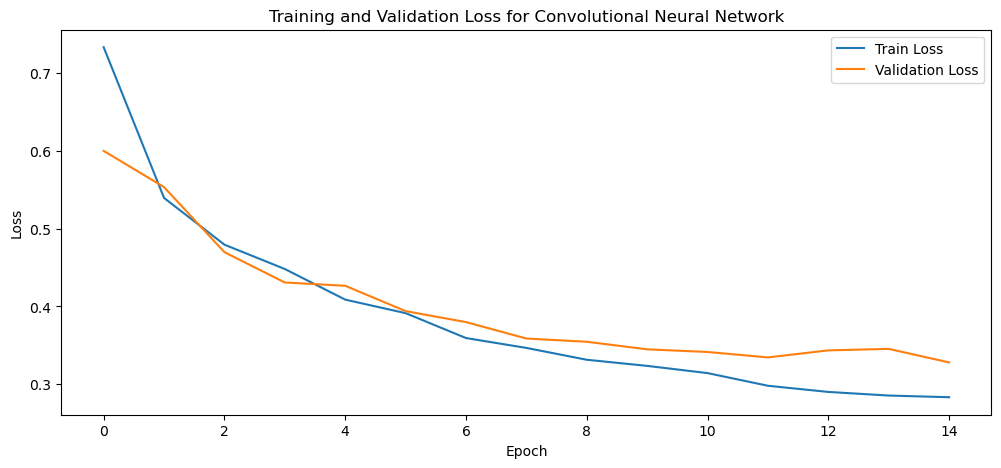

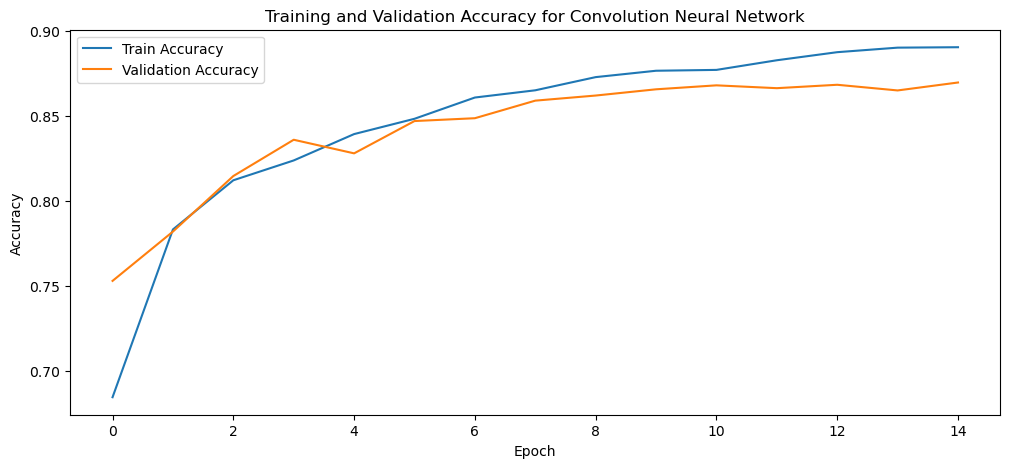

In [29]:
import matplotlib.pyplot as plt

# Plot Training Loss and Validation Loss vs Epochs
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')

plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training and Validation Loss for Convolutional Neural Network')

plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy for Convolution Neural Network')
plt.legend()

plt.show()


In [31]:
from sklearn.metrics import accuracy_score, f1_score


model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy and F1-score
test_accuracy = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Test Accuracy: 0.8767
Test F1-Score: 0.8775


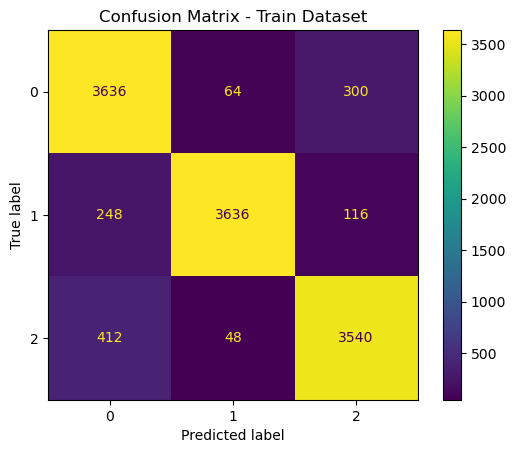

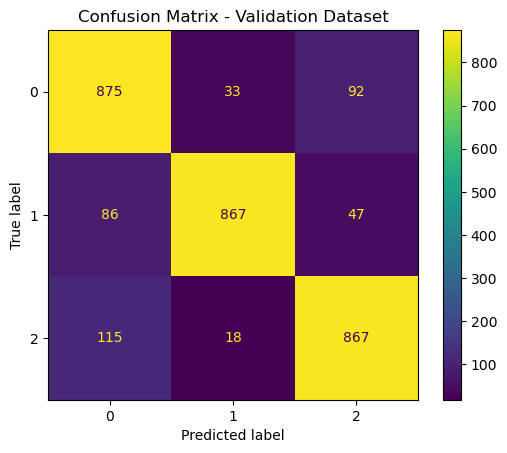

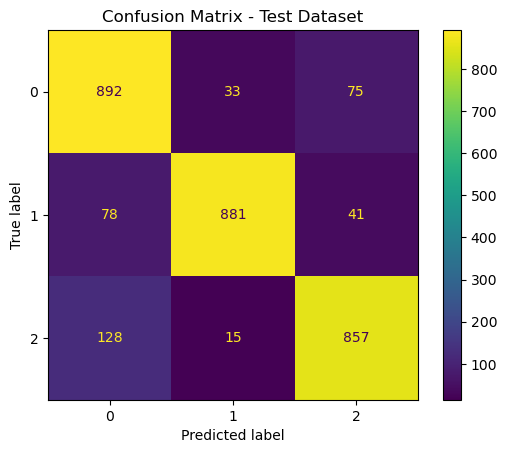

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np

def plot_confusion_matrix(dataloader, dataset_name):
    model.eval()
    
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))

    
    disp.plot(cmap='viridis')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.show()

# Plotting confusion matrix for train, val, and test datasets
plot_confusion_matrix(DataLoader(train_dataset, batch_size=batch_size, shuffle=False), "Train Dataset")

plot_confusion_matrix(DataLoader(val_dataset, batch_size=batch_size, shuffle=False), "Validation Dataset")

plot_confusion_matrix(DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False), "Test Dataset")



**Part (6)**

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    
    def __init__(self, num_classes):
        
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(32 * 32 * 3, 64)  # # First fully connected layer (64 neurons) flattened 32x32x3 image to a 1-D vector
        
        self.fc2 = nn.Linear(64, num_classes) # Second fully connected layer (classification head)

    def forward(self, x):
        
        x = x.view(-1, 32 * 32 * 3) #Flattenring the input imaage
        
        x = F.relu(self.fc1(x)) # First fully connected layer + ReLU activation
        
        x = self.fc2(x) # Second fully connected layer (output)
        
        return x


In [38]:
num_classes = 3 
model = MLP(num_classes)

In [40]:
import torch.optim as optim
from torch.utils.data import DataLoader

learning_rate = 0.001
num_epochs = 15
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#History for storing training and validation losses as well as training accuracy and validation accuracy over the span of 15 epochs
train_losses_mlp = []
val_losses_mlp = []
train_accuracies_mlp = []
val_accuracies_mlp = []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train = 0.0, 0
    
    total_train = 0
    
    # Training phase
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        
        correct_train += (predicted == labels).sum().item()
        
        total_train += labels.size(0)

    train_losses_mlp.append(train_loss / len(train_loader))
    train_accuracies_mlp.append(correct_train / total_train)
    
    # Validation phase
    model.eval()
    
    val_loss, correct_val = 0.0, 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_losses_mlp.append(val_loss / len(val_loader))
    
    val_accuracies_mlp.append(correct_val / total_val)
    
    print(
        f"Epoch Number: [{epoch+1}/{num_epochs}]: "
        f"Training Loss: {train_losses_mlp[-1]:.4f}, Train Accuracy: {train_accuracies_mlp[-1]:.4f}, "
        f"Validation Loss: {val_losses_mlp[-1]:.4f}, Validation Accuracy: {val_accuracies_mlp[-1]:.4f}"
    )


Epoch Number: [1/15]: Training Loss: 0.6779, Train Accuracy: 0.7266, Validation Loss: 0.6221, Validation Accuracy: 0.7577
Epoch Number: [2/15]: Training Loss: 0.5633, Train Accuracy: 0.7784, Validation Loss: 0.6201, Validation Accuracy: 0.7507
Epoch Number: [3/15]: Training Loss: 0.5215, Train Accuracy: 0.7971, Validation Loss: 0.5671, Validation Accuracy: 0.7800
Epoch Number: [4/15]: Training Loss: 0.4632, Train Accuracy: 0.8227, Validation Loss: 0.6033, Validation Accuracy: 0.7727
Epoch Number: [5/15]: Training Loss: 0.4267, Train Accuracy: 0.8330, Validation Loss: 0.6003, Validation Accuracy: 0.7707
Epoch Number: [6/15]: Training Loss: 0.4023, Train Accuracy: 0.8468, Validation Loss: 0.5856, Validation Accuracy: 0.7757
Epoch Number: [7/15]: Training Loss: 0.3736, Train Accuracy: 0.8602, Validation Loss: 0.7689, Validation Accuracy: 0.7210
Epoch Number: [8/15]: Training Loss: 0.3471, Train Accuracy: 0.8732, Validation Loss: 0.5985, Validation Accuracy: 0.7757
Epoch Number: [9/15]: Tr

In [42]:
torch.save(model.state_dict(), "mlp_model.pth")
print("Model saved to mlp_model.pth")


Model saved to mlp_model.pth


**Part (7)**

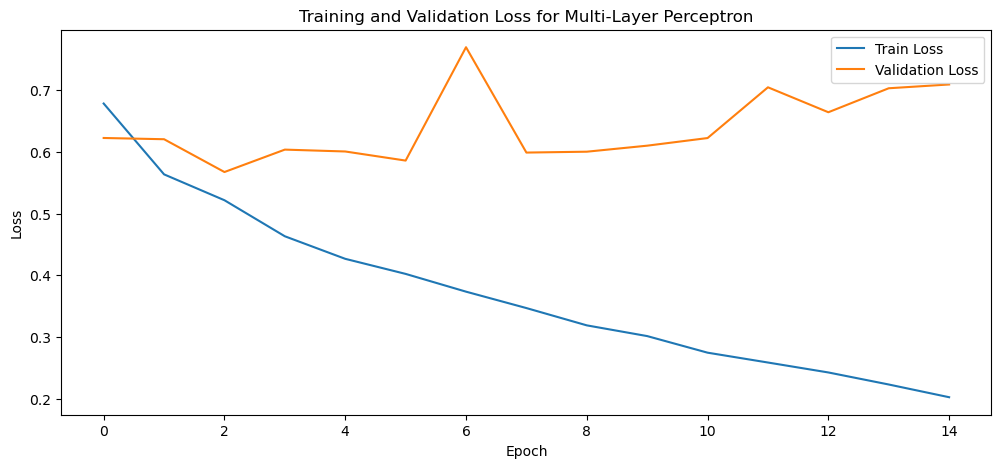

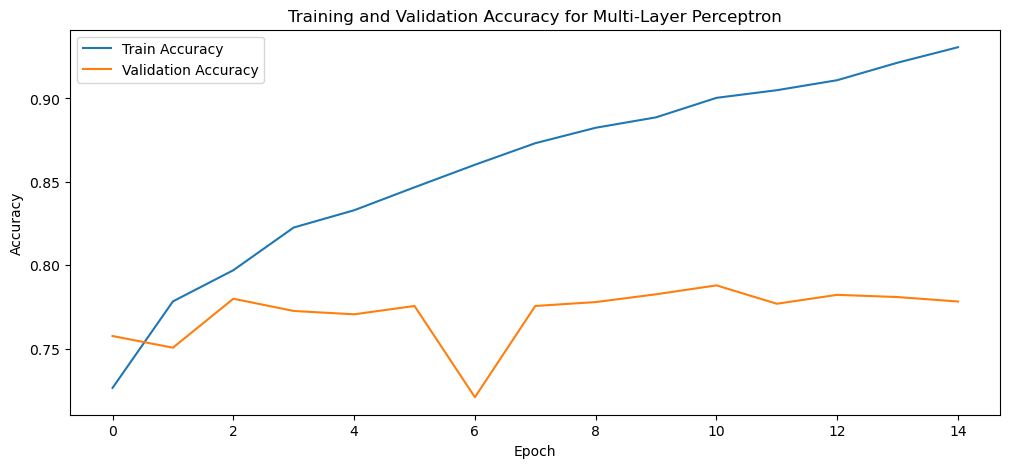

In [45]:
import matplotlib.pyplot as plt

# Plot Training Loss and Validation Loss vs Epochs
plt.figure(figsize=(12, 5))
plt.plot(train_losses_mlp, label='Train Loss')

plt.plot(val_losses_mlp, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training and Validation Loss for Multi-Layer Perceptron')

plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.plot(train_accuracies_mlp, label='Train Accuracy')
plt.plot(val_accuracies_mlp, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy for Multi-Layer Perceptron')
plt.legend()

plt.show()


In [47]:
model = MLP(num_classes)
model.load_state_dict(torch.load("mlp_model.pth"))
model.eval()  

/var/folders/0q/sqss7b0n3399xjy7cngwg30w0000gn/T/ipykernel_54481/3189226448.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mlp_model.p

MLP(
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [49]:
from sklearn.metrics import accuracy_score, f1_score


model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)

test_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Test Accuracy: 0.8147
Test F1-Score: 0.8148


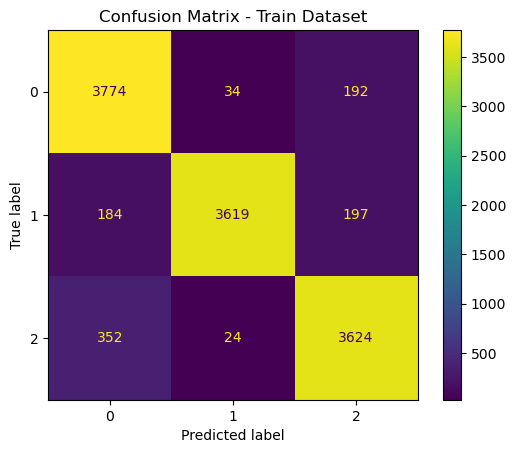

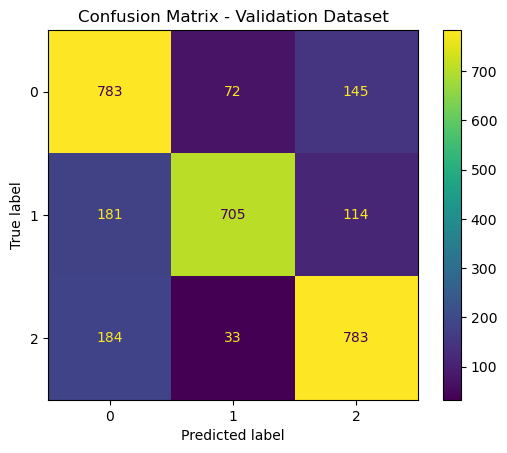

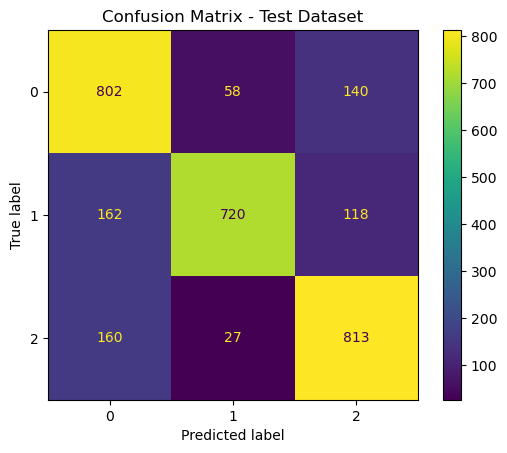

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

testing_loader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False)

# Plotting confusion matrix for train, val, and test datasets
plot_confusion_matrix(train_loader, "Train Dataset")

plot_confusion_matrix(validation_loader, "Validation Dataset")

plot_confusion_matrix(testing_loader, "Test Dataset")

